Firstly, import the fortran disk model routines and the python likelihood functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskfit import likelihood, utils
from scipy.optimize import minimize

Load the continuum subtracted spectrum. Establish the redshift and narrow line width in Angstroms. 

In [2]:
fn = '../data/ZTF18aahiqst_subtracted.txt'
wl,flux,fluxerr = utils.readspec(fn)
z = 0.0745
narrowwidth = 3.9

Extract the region of the spectrum containing the double-peaked profile, and store the size of the spectrum in npix

In [3]:
olambda = 6564.614#6563 # nominal wavelength of the Halpha line (Angstrom)
wavemin = 6300  # minimum wavelength (Angstrom)
wavemax = 6900  # maximum wavelength (Angstrom)
wave = wl/(1+z) # Convert the spectrum to rest frame wavelength
indwave = np.argwhere((wave>wavemin)&(wave<wavemax))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
flux = flux[indwave]
fluxerr = fluxerr[indwave]
npix = wl.shape[0]

Set all the parameters which will remain fixed to pre-determined values during the fitting

In [4]:
fixed_labels = ['z','narrowwidth']
fixed_values = [z, narrowwidth]

Create a dictionary of the fixed parameter names and values

In [5]:
fixed = dict(zip(fixed_labels,fixed_values))

Set initial guesses for the parameters to be fitted

In [11]:
broadlam = olambda # Central broad line wavelength in Angstrom
broadwidth = 50 # Gaussian width in Angstrom

Create a dictionary of fitted parameter names and values

In [12]:
fitted_labels = ['broadlam','broadwidth']
initial = [broadlam, broadwidth]
fitted = dict(zip(fitted_labels,initial))

Set wavelengths of narrow emission lines to be included in the fit and create the array of line profiles

In [13]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]

Plot initial model against spectrum

In [14]:
modelguess = likelihood.model_linefit_broad(initial, wl, flux, fluxerr, lines, fixed, fitted)

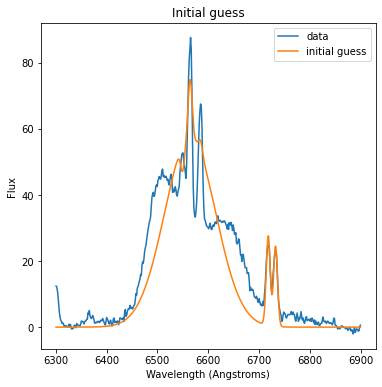

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize=(6,6))
plt.plot(wl/(1+z),flux,label='data')
plt.plot(wl/(1+z),modelguess,label='initial guess')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Initial guess')
plt.legend()
plt.show()
plt.clf()

Establish bounds for fitted parameters. These will be used to make a uniform prior.

In [17]:
broadmumax = broadlam-20
broadmumin= broadlam+20
broadwidthmin = narrowwidth*2
broadwidthmax = 150
diskmins = [broadmumin,broadwidthmin]
diskmax = [broadmumax,broadwidthmax]

In [18]:
lp = likelihood.logprob_broad(wl, flux, fluxerr, lines, fixed, fitted, diskmins, diskmax)

Use scipy.optimize.minimize to find a simple solution for the fitted parameters

In [19]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)
print('Best-fit parameter values', soln.x)

Best-fit parameter values [6566.61500855   72.99004596]


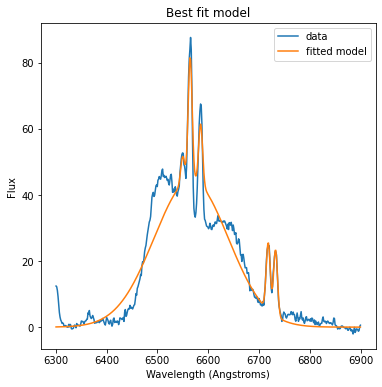

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figsize=(6,6))
plt.plot(wl/(1+z),flux,label='data')
plt.plot(wl/(1+z),modelfit,label='fitted model')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Best fit model')
plt.legend()
plt.show()
plt.clf()

Now import the emcee module to sample the parameter space, with walkers initialized around the best fit parameters from the previous step. Run the sampler for 1000 iterations and save the progress to file. 

In [21]:
import emcee
pos = soln.x + 1e-2 * soln.x * np.random.randn(20, soln.x.shape[0])
nwalkers, ndim = pos.shape
filename ='broad_emcee.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 400, progress=True)

100%|██████████████████████████████████| 400/400 [00:40<00:00,  9.88it/s]


State([[6566.65164106   73.4959647 ]
 [6566.84933477   72.58462882]
 [6566.7002806    73.21679085]
 [6566.45481362   72.60453342]
 [6566.85929774   73.1968069 ]
 [6566.41912511   72.99646927]
 [6567.22909536   73.40412851]
 [6566.4872622    73.61657502]
 [6566.85135599   72.92525888]
 [6566.59416218   72.99075406]
 [6566.80245989   73.5255203 ]
 [6566.11493644   72.60665661]
 [6566.69823161   73.13552833]
 [6566.19953989   73.09903471]
 [6566.54067197   73.13541388]
 [6567.26795966   72.91740924]
 [6566.38983626   72.6618851 ]
 [6567.36885106   73.13493192]
 [6566.05535845   73.15541722]
 [6567.32244223   73.2004615 ]], log_prob=[-2887.33228055 -2887.49475913 -2886.25461513 -2886.74419288
 -2886.36511017 -2886.19737519 -2887.96200137 -2888.45941239
 -2886.35308879 -2886.0045555  -2887.39841099 -2887.427985
 -2886.11228176 -2887.07274758 -2886.18013686 -2888.30160724
 -2886.60340618 -2888.56915676 -2888.00940168 -2888.22955069], blobs=None, random_state=('MT19937', array([1067812510, 11

Print the parameters and uncertainties found by the sampler

In [22]:
from IPython.display import display, Math
flat_samples = sampler.get_chain(discard=200, flat=True)
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Make a corner plot of the parameter samples

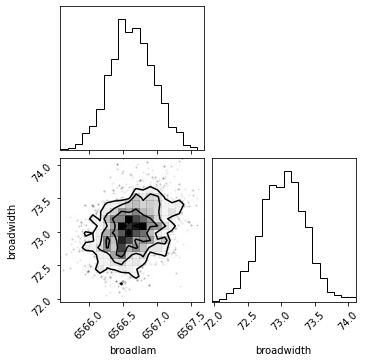

In [23]:
import corner
fig = corner.corner(
            flat_samples, labels=fitted_labels)
plt.show()

Plot the sampler chains 

<Figure size 432x432 with 0 Axes>

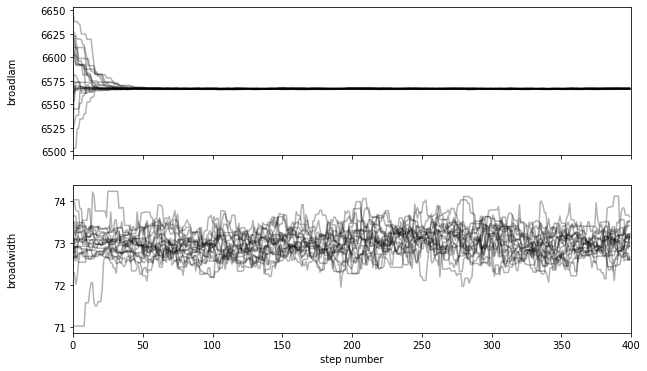

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(soln.x.shape[0], figsize=(10,3*soln.x.shape[0]), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(fitted_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()
plt.clf()

Plot the range of good fits found by the sampler

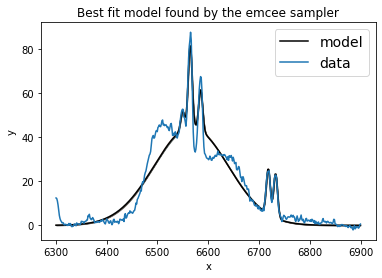

<Figure size 432x288 with 0 Axes>

In [25]:
from ultranest.plot import PredictionBand
band = PredictionBand(wl/(1+z))
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    modelfit = lp.test(sample)
    band.add(modelfit)
    plt.plot(wl/(1+z),modelfit,alpha=0.1)

band.line(color='k',label='model')
# add 1 sigma quantile
band.shade(color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2);

plt.plot(wl/(1+z),flux,label='data')
plt.title('Best fit model found by the emcee sampler')
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");
plt.show()
plt.clf()